# Using embeddings to represent week days
(actually mostly python tricks I've learned)



### Dataset
* A count of bicycles rides across East River bridges
* https://www.kaggle.com/new-york-city/nyc-east-river-bicycle-crossings 

        

### Task
* Represent weekdays by using categorical embeddings
* Effectively python version of: http://flovv.github.io/Embeddings_with_keras/

In [41]:
%matplotlib notebook
import keras
from keras import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Dropout, Activation, Flatten

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

import pandas as pd
import numpy as np

from plotnine import *
from plotnine import options
options.set_option('figure_size' , (10,6))

    
import matplotlib.pyplot as plt

import seaborn as sns

from pandas.api.types import CategoricalDtype
import warnings
warnings.filterwarnings('ignore')

In [42]:
df = pd.read_csv("~/.kaggle/datasets/new-york-city/nyc-east-river-bicycle-crossings/nyc-east-river-bicycle-counts.csv")
df['date'] = pd.to_datetime(df['Date'])
df['weekday'] = df['date'].dt.weekday
df['weekday_name'] = df['date'].dt.weekday_name

bridge = 'Total'
by_day = df.groupby('weekday_name')[[bridge]].sum()

## ggplot2 in python!

<IPython.core.display.Javascript object>


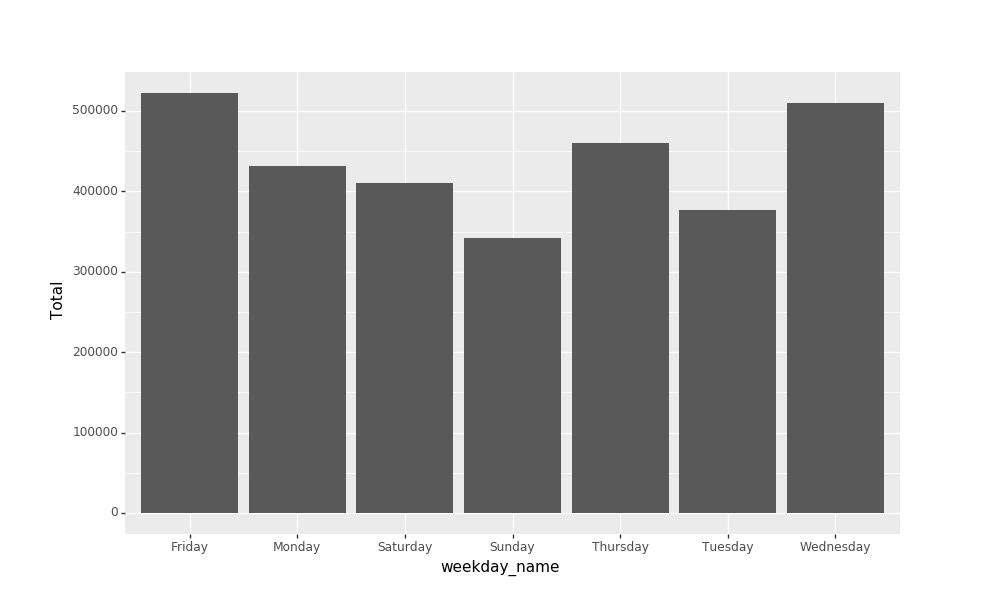

<ggplot: (-9223363250860512403)>

In [43]:
from plotnine import *
ggplot(by_day.reset_index(), aes('weekday_name', bridge)) + geom_bar(stat = 'identity')

### Ordered categorical variable in pandas

In [45]:
from pandas.api.types import CategoricalDtype
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_type = CategoricalDtype(categories=weekdays, ordered=True)
df['weekday_name'] = df['weekday_name'].astype(weekday_type)
by_day = df.groupby('weekday_name')[[bridge]].sum()

<IPython.core.display.Javascript object>


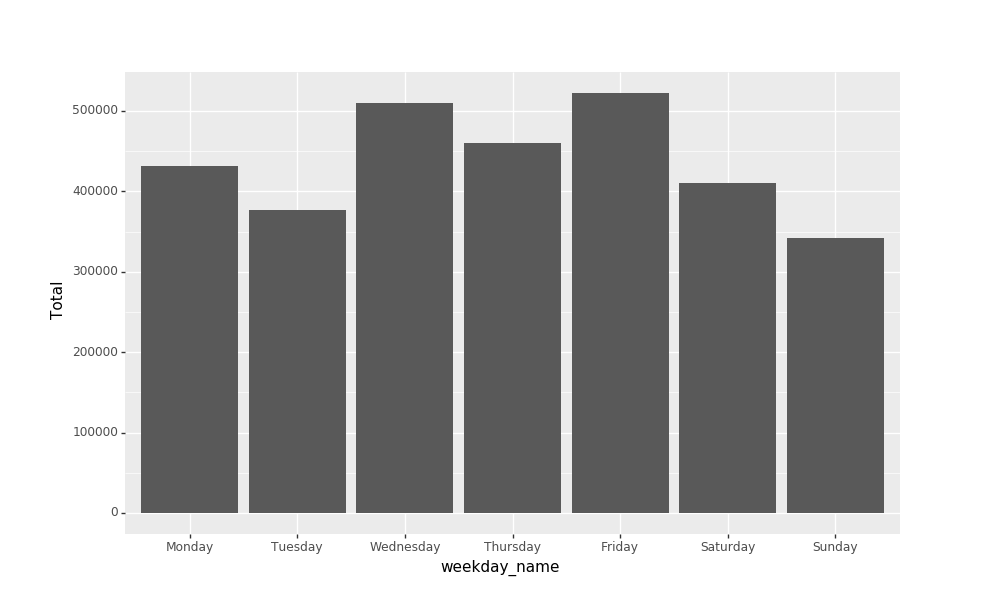

<ggplot: (-9223363250860575656)>

In [46]:
ggplot(by_day.reset_index(), aes('weekday_name', bridge)) + geom_bar(stat = 'identity')

### Pre-processing

In [47]:
df['users'] = df['Brooklyn Bridge']

df = df[df['users'] > 0]
df['scaled_users'] = (df['users'] - np.mean(df['users']))/np.std(df['users'])

emb_size = 3
embedding_names = [f'D{x+1}' for x in np.arange(emb_size)]

In [48]:
model = keras.Sequential()
model.add(Embedding(input_dim=7, output_dim=emb_size, input_length=1, name="embedding"))
model.add(Flatten())
model.add(Dense(units=40, activation='relu'))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1))
model.compile(loss='mse', optimizer='sgd')

In [49]:
hh = model.fit(x=df[['weekday']], y=df[['scaled_users']], epochs=50,batch_size=2)

Epoch 1/50
210/210 [==============================] - 0s 937us/step - loss: 1.0064
Epoch 2/50
210/210 [==============================] - 0s 510us/step - loss: 0.9979
Epoch 3/50
210/210 [==============================] - 0s 517us/step - loss: 0.9875
Epoch 4/50
210/210 [==============================] - 0s 518us/step - loss: 0.9660
Epoch 5/50
210/210 [==============================] - 0s 509us/step - loss: 0.9497
Epoch 6/50
210/210 [==============================] - 0s 514us/step - loss: 0.9334
Epoch 7/50
210/210 [==============================] - 0s 513us/step - loss: 0.9190
Epoch 8/50
210/210 [==============================] - 0s 503us/step - loss: 0.9116
Epoch 9/50
210/210 [==============================] - 0s 512us/step - loss: 0.9138
Epoch 10/50
210/210 [==============================] - 0s 506us/step - loss: 0.9100
Epoch 11/50
210/210 [==============================] - 0s 521us/step - loss: 0.9072
Epoch 12/50
210/210 [==============================] - 0s 533us/step - loss: 0.8979
E

In [50]:
mm = model.get_layer('embedding')
emb_matrix = mm.get_weights()[0]
emb_matrix

array([[-0.05626222,  0.04770591,  0.20970954],
       [ 0.20515893, -0.17663999, -0.10393152],
       [-0.4766545 ,  0.39117068,  0.14561543],
       [-0.11553285,  0.07674664,  0.1321006 ],
       [-0.05854096,  0.02401886, -0.01307055],
       [ 0.4257923 , -0.3092957 , -0.31917801],
       [ 0.22764297, -0.15471804, -0.11441667]], dtype=float32)

In [51]:
emp_df = pd.DataFrame(emb_matrix, columns = embedding_names)
emp_df['weekday'] = np.arange(0,7)

df = pd.merge(df, emp_df, on = 'weekday')
dummyw = pd.get_dummies(df['weekday_name'])
df_X = pd.concat([df, dummyw], ignore_index= False, axis = 1)
    
y = (df_X['Williamsburg Bridge'] - np.mean(df_X['Williamsburg Bridge']))/np.std(df_X['Williamsburg Bridge'])

all_x = embedding_names + weekdays
df_X = df_X[all_x]
    
model = LinearRegression()
dummy_x = df_X[weekdays]
emb_x = df_X[embedding_names]

In [52]:
bootstrap = ShuffleSplit(n_splits=100, random_state=0, test_size=0.2)

dummy_scores = cross_val_score(model,dummy_x, y, scoring="neg_mean_squared_error", cv=bootstrap)
emb_scores = cross_val_score(model, emb_x, y, scoring="neg_mean_squared_error", cv=bootstrap)

scores = pd.DataFrame({ 'dummy':-dummy_scores, 'embedded':-emb_scores})
scores.mean()

dummy       0.936436
embedded    0.908810
dtype: float64

<IPython.core.display.Javascript object>


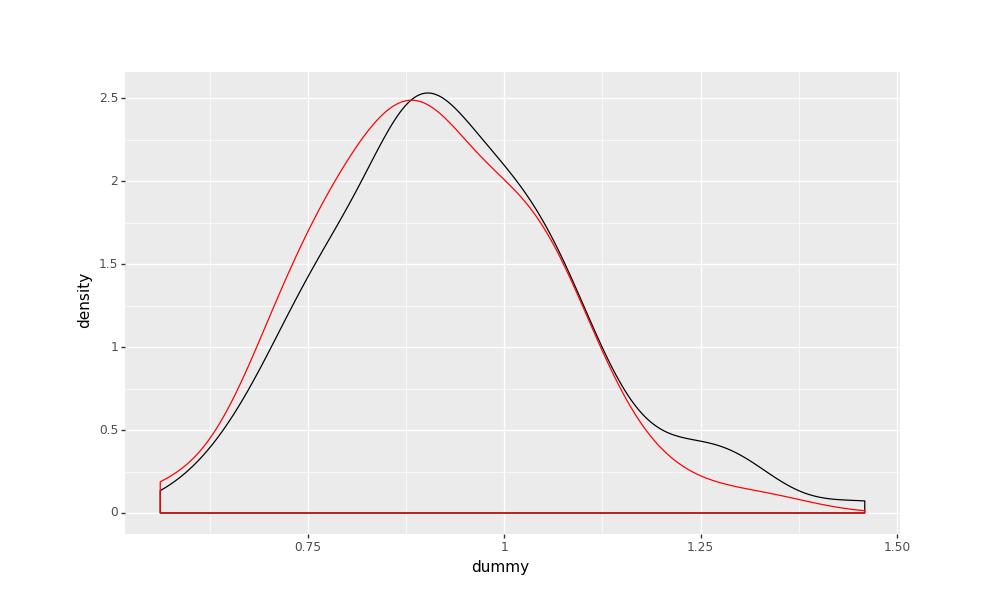

<ggplot: (8785994180030)>

In [59]:
ggplot(scores, aes('dummy')) + geom_density() + geom_density(aes('embedded'), color = 'red')

In [61]:
corr_mat = emp_df.drop('weekday', axis = 1).transpose().corr()
corr_mat.columns = weekdays 
corr_mat['weekdays_name'] = weekdays
corr_mat.set_index('weekdays_name', inplace = True)

corr_mat



,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
weekdays_name,,,,,,,
Monday,1.000000,-0.675453,0.600275,0.907152,0.441099,-0.803674,-0.735102
Tuesday,-0.675453,1.000000,-0.995228,-0.923040,-0.959730,0.981650,0.996454
Wednesday,0.600275,-0.995228,1.000000,0.881096,0.982562,-0.958359,-0.983489
Thursday,0.907152,-0.923040,0.881096,1.000000,0.777797,-0.979462,-0.952135
Friday,0.441099,-0.959730,0.982562,0.777797,1.000000,-0.888550,-0.932690
Saturday,-0.803674,0.981650,-0.958359,-0.979462,-0.888550,1.000000,0.994214
Sunday,-0.735102,0.996454,-0.983489,-0.952135,-0.932690,0.994214,1.000000


<IPython.core.display.Javascript object>


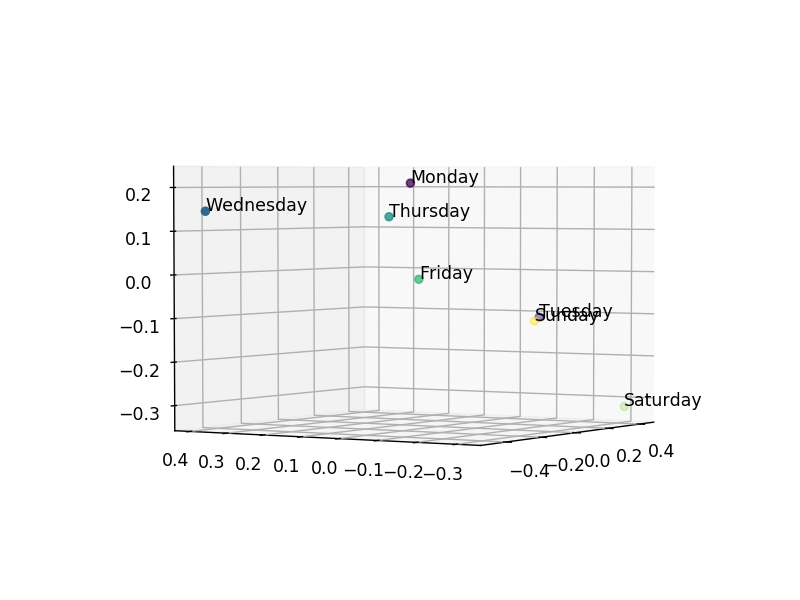

In [63]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(xs = emp_df['D1'], ys = emp_df['D2'], zs = emp_df['D3'], c = emp_df['weekday'])

for row_num, day in emp_df.iterrows():
    ax.text(x = day['D1'] , y = day['D2'], z = day['D3'], s = weekdays[row_num])

plt.show()

# Questions?

